In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
import numpy as np

adult = pd.read_csv("adult_with_pii.csv")
def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)
def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0


# Variants of Differential Privacy

```{admonition} Learning Objectives
After reading this chapter, you will be able to:
- Define Rényi differential privacy and zero-concentrated differential privacy
- Describe the advantages of these variants over $(\epsilon, \delta)$-differential privacy
- Convert privacy costs from these variants into $(\epsilon, \delta)$-differential privacy
```

Recall that most of the bounds on privacy cost we have shown are *upper* bounds, but they sometimes represent very loose upper bounds - the true privacy cost is much less than the upper bound says. The primary motivation in developing new variants of differential privacy is to enable tighter bounds on privacy cost - especially for iterative algorithms - while maintaining privacy definitions which are useful in practice. For example, the catastrophic failure mode of $(\epsilon, \delta)$-differential privacy is not desirable; the variants we'll see in this section enable even tighter composition for some kinds of queries, while at the same time *eliminating* the catastropic failure mode.

Let's take a quick look at the tools we have already seen; we'll look first at sequential composition for $\epsilon$-differential privacy. It turns out that sequential composition for $\epsilon$-differential privacy is *tight*. What does that mean? It means there's a counterexample that would fail to satisfy any lower bound:
- A mechanism $F$ exists which satisfies $\epsilon$-differential privacy
- When composed $k$ times, $F$ satisfies $k\epsilon$-differential privacy
- But $F$ does *not* satisfy $c\epsilon$-differential privacy for any $c < k$

A neat way to visualize this is to look at what happens to privacy cost when we "vectorize" a query: that is, we merge lots of queries into a single query which returns a vector of the individual answers. Because the answer is a vector, we can use the vector-valued Laplace mechanism just once, and avoid composition altogether. Below, we'll graph how much noise is needed for $k$ queries, first under sequential composition, and then using the "vectorized" form. In the sequential composition case, each query has a sensitivity of 1, so the scale of the noise for each one is $\frac{1}{\epsilon_i}$. If we want a total privacy cost of $\epsilon$, then the $\epsilon_i$s must add up to $\epsilon$, so $\epsilon_i = \frac{\epsilon}{k}$. This means that each query gets Laplace noise with scale $\frac{k}{\epsilon}$. In the "vectorized" case, there's just one query, but it has an L1 sensitivity of $\sum_{i=1}^k 1 = k$, so the scale of the noise is $\frac{k}{\epsilon}$ in this case too.

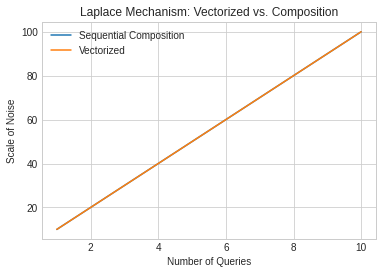

In [12]:
ks = np.linspace(1, 10, 20)
epsilon = .1

# L1 sensitivity of each query: 1
# noise per query: 1/epsilon
# number of queries: k
noises_seq = [k*(1/epsilon) for k in ks]
plt.plot(ks, noises_seq, label='Sequential Composition')

# number of queries: 1
# L1 sensitivity of each query: k
# noise per query: k / epsilon
noises_l1 = [1*(k/epsilon) for k in ks]
plt.plot(ks, noises_l1, label='Vectorized')
plt.title('Laplace Mechanism: Vectorized vs. Composition')
plt.xlabel('Number of Queries')
plt.ylabel('Scale of Noise')
plt.legend();

The two lines overlap *completely*. This means that no matter how many queries we're running, under $\epsilon$-differential privacy, we can't do any better than sequential composition. That's because sequential composition is just as good as vectorizing the query, and we can't do any better than that.

What about $(\epsilon, \delta)$-differential privacy? The story is a little different there. In the sequential composition case, we can use advanced composition; we have to be a little careful to ensure that the total privacy cost is exactly $(\epsilon, \delta)$. Specifically, we set $\epsilon_i = \frac{\epsilon}{2 \sqrt{2k \log(1/\delta')}}$, $\delta_i = \frac{\delta}{2k}$, and $\delta' = \frac{\delta}{2}$ (splitting $\delta$ to go 50% towards the queries, and 50% towards advanced composition). By advanced composition, the total privacy cost for all $k$ queries is $(\epsilon, \delta)$. The scale of the noise, by the Gaussian mechanism, is:

\begin{align}
\sigma^2 =& \frac{2 \log(\frac{1.25}{\delta_i})}{\epsilon_i^2}\\
 =& \frac{16 k \log(\frac{1}{\delta'}) \log(\frac{1.25}{\delta_i})}{\epsilon^2}\\
 =& \frac{16 k \log(\frac{2}{\delta}) \log(\frac{2.5 k}{\delta})}{\epsilon^2}\\
\end{align}

In the "vectorized" case, we have just one query, with an L2 sensitivity of $\sqrt{k}$. The scale of the noise, by the Gaussian mechanism, is $\sigma^2 = \frac{2 k \log(1.25/\delta)}{\epsilon^2}$.

What does this difference mean in practice? The two behave the same asymptotically in $k$, but have different constants, and the advanced composition case has an additional logarithmic factor in $\delta$. All this adds up to a much looser bound in the case of advanced composition. Let's graph the two as we did before.

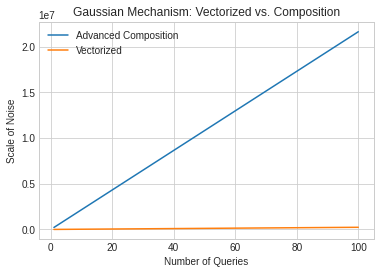

In [14]:
ks = np.linspace(1, 100, 20)
epsilon = .1
delta = 1e-5

# L2 sensitivity of each query: 1
# number of queries: k
noises_seq = [16*k*np.log(1.25/delta)*np.log(1/delta)/(epsilon**2) for k in ks]
plt.plot(ks, noises_seq, label='Advanced Composition')

# number of queries: 1
# L2 sensitivity of each query: sqrt(k)
noises_l1 = [2*k*np.log(1.25/delta)/(epsilon**2) for k in ks]
plt.title('Gaussian Mechanism: Vectorized vs. Composition')
plt.xlabel('Number of Queries')
plt.ylabel('Scale of Noise')
plt.plot(ks, noises_l1, label='Vectorized')
plt.legend();

It's not even close - the "vectorized" version grows *much* slower. What does this mean? We should be able to do *much* better for sequential composition!

## Max Divergence and Rényi Divergence

It turns out that the definition of differential privacy can be stated directly in terms of something called *max divergence*. In statistics, a [*divergence*](https://en.wikipedia.org/wiki/Divergence_(statistics)) is a way of measuring the distance between two probability distributions - which is exactly what we want to do for differential privacy. The *max divergence* is the worst-case analog of the [Kullback–Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence), one of the most common such measures. The max divergence between two probability distributions $Y$ and $Z$ is defined to be:

\begin{align}
D_\infty(Y \Vert Z) = \max_{S \subseteq \text{Supp}(Y)} \Big[\log \frac{Pr[Y \in S]}{Pr[Z \in S]} \Big]
\end{align}

This already looks a lot like the condition for $\epsilon$-differential privacy! In particular, it turns out that $F$ satisfies $\epsilon$-differential privacy if:

\begin{align}
D_\infty(F(x) \Vert F(x') \leq \epsilon
\end{align}

An interesting direction for research in differential privacy is the exploration of alternative privacy definitions in terms of other divergences. Of these, the [Rényi divergence](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy#R%C3%A9nyi_divergence) is particularly interesting, since it also (like max divergence) allows us to recover the original definition of differential privacy. The Rényi divergence of order $\alpha$ between probability distributions $P$ and $Q$ is defined as (where $P(x)$ denotes the probability density of $P$ at point $x$):

\begin{align}
D_\alpha(P \Vert Q) = \frac{1}{\alpha - 1} \log E_{x \sim Q} \Big(\frac{P(x)}{Q(x)}\Big)^\alpha
\end{align}

If we set $\alpha = \infty$, then we immediately recover the definition of $\epsilon$-differential privacy! The obvious question arises: what happens if we set $\alpha$ to something else? As we'll see, it's possible to use the Rényi divergence to derive really interesting relaxations of differential privacy that allow better composition theorems while at the same time avoiding the possibility of "catastrophe" which is possible under $(\epsilon, \delta)$-differential privacy.

## Rényi Differential Privacy

In 2017, Ilya Mironov proposed [Rényi differential privacy (RDP)](https://arxiv.org/abs/1702.07476) {cite}`mironov2017renyi`. A randomized mechanism $F$ satisfies $(\alpha, \bar{\epsilon})$-RDP if for all neighboring datasets $x$ and $x'$

\begin{align}
D_\alpha(F(x) \Vert F(x')) \leq \bar{\epsilon}
\end{align}

In other words, RDP requires that the Rényi divergence of order $\alpha$ between $F(x)$ and $F(x')$ to be bounded by $\bar{\epsilon}$. Note that we'll use $\bar{\epsilon}$ to denote the $\epsilon$ parameter of RDP, in order to distinguish it from the $\epsilon$ in pure $\epsilon$-differential privacy and $(\epsilon, \delta)$-differential privacy.

A key property of Rényi differential privacy is that a mechanism which satisfies RDP also satisfies $(\epsilon, \delta)$-differential privacy. Specifically, if $F$ satisfies $(\alpha, \bar{\epsilon})$-RDP, then for $\delta > 0$, $F$ satisfies $(\epsilon, \delta)$-differential privacy for $\epsilon = \bar{\epsilon} + \frac{\log(1/\delta)}{\alpha - 1}$. The analyst is free to pick any value of $\delta$; a meaningful value (e.g. $\delta \leq \frac{1}{n^2}$) should be picked in practice.

The basic mechanism for achieving Rényi differential privacy is the Gaussian mechanism. Specifically, for a function $f : \mathcal{D} \rightarrow \mathbb{R}^k$ with $L2$ sensitivity $\Delta f$, the following mechanism satisfies $(\alpha, \bar{\epsilon})$-RDP:

\begin{align}
F(x) = f(x) + \mathcal{N}(\sigma^2) \text{ where } \sigma^2 = \frac{\Delta f^2 \alpha}{2\epsilon}
\end{align}

We can implement the Gaussian mechanism for Rényi differential privacy as follows:

In [2]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

The major advantage of Rényi differential privacy is *tight composition* for the Gaussian mechanism - and this advantage in composition comes without the need for a special advanced composition theorem. The sequential composition theorem of Rényi differential privacy states that:

- If $F_1$ satisfies $(\alpha, \bar{\epsilon_1})$-RDP
- And $F_2$ satisfies $(\alpha, \bar{\epsilon_2})$-RDP
- Then their composition satisfies $(\alpha, \bar{\epsilon_1} + \bar{\epsilon_2})$-RDP

Based on this sequential composition theorem, running an $(\alpha, \bar{\epsilon})$-RDP mechanism $k$ times results in $(\alpha, k\bar{\epsilon})$-RDP. For a given level of noise (i.e. a given value for $\sigma^2$), bounding the privacy cost of repeated applications of the Gaussian mechanism using RDP's sequential composition, and *then* converting to $(\epsilon, \delta)$-differential privacy, will usually yield a *much* lower privacy cost than performing the composition directly in $(\epsilon, \delta)$ world (even with advanced composition).

As a result, the ideas behind Rényi differential privacy have been used to greatly improve the privacy cost accounting in a number of recent iterative algorithms, including Google's [differentially private version of Tensorflow](https://github.com/tensorflow/privacy).

Finally, like other variants of differential privacy, RDP provides a post-processing property.

## Zero-Concentrated Differential Privacy

In concurrent work released in 2016, Mark Bun and Thomas Steinke proposed [zero-concentrated differential privacy (zCDP)](https://arxiv.org/abs/1605.02065) {cite}`bun2016concentrated`. Like RDP, zCDP is defined in terms of the Rényi divergence, but it includes only a single privacy parameter ($\rho$). A randomized mechanism $F$ satisfies $\rho$-zCDP if for all neighboring datasets $x$ and $x'$, and all $\alpha \in (1, \infty)$:

\begin{align}
D_\alpha (F(x) \Vert F(x')) \leq \rho\alpha
\end{align}

This is a stronger requirement than RDP, because it restricts the Rényi divergence of many orders; however, the bound becomes more relaxed as $\alpha$ grows. Like RDP, zCDP can be converted to $(\epsilon, \delta)$-differential privacy: if $F$ satisfies $\rho$-zCDP, then for $\delta > 0$, $F$ satisfies $(\epsilon, \delta)$-differential privacy for $\epsilon = \rho + 2\sqrt{\rho \log(1/\delta)}$.

zCDP is also similar to RDP in that the Gaussian mechanism can be used as a basic mechanism. Specifically, for a function $f : \mathcal{D} \rightarrow \mathbb{R}^k$ with $L2$ sensitivity $\Delta f$, the following mechanism satisfies $\rho$-zCDP:

\begin{align}
F(x) = f(x) + \mathcal{N}(\sigma^2) \text{ where } \sigma^2 = \frac{\Delta f^2}{2\rho}
\end{align}

As with RDP, this mechanism is easy to implement:

In [3]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2) / (2 * rho))
    return [v + np.random.normal(loc=0, scale=sigma) for v in vec]

In another similarity with RDP, zCDP's sequential composition is also asymptotically tight for repeated applications of the Gaussian mechanism. It's also very simple: the $\rho$s add up. Specifically:

Sequential composition:
- If $F_1$ satisfies $\rho_1$-zCDP
- And $F_2$ satisfies $\rho_2$-zCDP
- Then their composition satisfies $\rho_1+\rho_2$-zCDP

Finally, zCDP also provides a post-processing property.

## Truncated Concentrated Differential Privacy

**Coming soon** {cite}`bun2018composable`

## Composition under Variants of Differential Privacy

Which variant should we use, and when?

The recently-developed variants will yield *significantly* tighter bounds on privacy cost when:

- The Gaussian mechanism is used (especially on high-dimensional vectors)
- The algorithm in question applies the mechanism many times (e.g. hundreds or thousands of times)

To use RDP and zCDP, we typically implement an algorithm in terms of the variant we want to use, and then convert the total privacy cost of running the algorithm back to $(\epsilon, \delta)$-differential privacy so that we can compare it to other algorithms. 

To see the effect of this strategy, let's imagine an algorithm that applies the Gaussian mechanism $k$ times. We'll fix values for $\sigma$ (i.e. the amount of noise added with the Gaussian mechanism in each of the $k$ iterations) and $\delta$, and then compare the final $\epsilon$s achieved for each variant. 

We'll see that composition under RDP and zCDP result in *smaller values of $\epsilon$ for the same amount of noise added*. The algorithm is identical under all variants (i.e. it adds the same amount of noise in each case) - so this means that RDP and zCDP are providing *significantly tighter bounds on privacy cost* for the *same algorithm*.

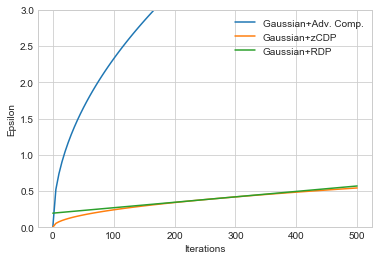

In [19]:
sigma = 200.0
delta = 1e-5
lap_eps = 2*sigma**2
xs = np.linspace(0, 500, 100)

gauss_eps = np.sqrt(2 * np.log(1.25/delta) / sigma**2)

ys_gauss_adv = [2 * gauss_eps * np.sqrt(2 * x * np.log(1/delta)) for x in xs]

rho = 1/(2*sigma**2)
ys_gauss_zcdp = [(x*rho) + 2*np.sqrt((x*rho) * np.log(1/delta)) for x in xs]

alpha = 60
rdp_eps = alpha / (2*sigma**2)

ys_gauss_rdp = [(x*rdp_eps) + np.log(1/delta)/(alpha-1) for x in xs]

ys_moments = [4*np.sqrt(x*np.log(1/delta))/sigma for x in xs]

plt.plot(xs, ys_gauss_adv, label="Gaussian+Adv. Comp.")
plt.plot(xs, ys_gauss_zcdp, label="Gaussian+zCDP")
plt.plot(xs, ys_gauss_rdp, label="Gaussian+RDP")
#plt.plot(xs, ys_moments, label="Moments Accountant")

plt.xlabel('Number of Iterations')
plt.ylabel('Epsilon')
plt.ylim(0, 3.0)


plt.legend()
plt.show();

The first thing to note is that using sequential composition under either zCDP or RDP is *much* better than using advanced composition with $(\epsilon, \delta)$-differential privacy. When building iterative algorithms with the Gaussian mechanism, these variants should always be used.

The second thing to note is the difference between zCDP (in orange) and RDP (in green). The $\epsilon$ for RDP grows linearly in $k$, because we have fixed a value for $\alpha$. The $\epsilon$ for zCDP is sublinear in $k$, since zCDP effectively considers many $\alpha$s. The two lines touch at some value of $k$, depending on the $\alpha$ chosen for RDP (for $\alpha = 20$, they touch at roughly $k=300$).

The practial effect of this difference is that $\alpha$ must be chosen carefully when using RDP in order to bound privacy cost as tightly as possible. This is usually easy to do, since algorithms are usually parameterized by $\alpha$; as a result, we can simply test multiple values of $\alpha$ to see which one results in the smallest corresponding $\epsilon$. Since this test is *independent* of the data (it depends mainly on the privacy parameters we pick, and the number of iterations we want to run), we can test as many values of $\alpha$ as we want without paying additional privacy cost. We only need to test a small range of values for $\alpha$ - typically in the range between 2 and 100 - to find a minimum. This is the approach taken in most practical implementations, including Google's privacy-preserving version of Tensorflow.